# Polynomial Regression

One trick to adapt linear regression to nonlinear relationships between variables is to transform the data according to **polynomials**.

The idea is to take the multidimensional linear model:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \cdots
$$

and build the features $x_1, x_2, x_3,$ and so on, from a single-dimensional input $x$.
That is, let $x_n = x^n$, we have the feature mapping:

$$
x \mapsto \{1, x, x^2,\dots, x^n\}
$$

then our model becomes a polynomial regression:
$$
y = \beta_0 + \beta_1 x + \beta_2 x^2 + \cdots  + \beta_n x^n
$$

This is **still a linear function** of $\boldsymbol\beta$, yet non-linear in $x$.

What we have effectively done is taken one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$. 

For multi-features $\{x_1, x_2, \dots, x_p\}$, we can also do feature mapping through polynomial functions of  degree at most $n$:

$$
\{x_1, x_2, \dots, x_p\} \mapsto \left\{x_1^{d_1} x_2^{d_2} \dots x_p^{d_p}: d_k\in\mathbb{N}, \; 0\leq \sum_{k=1}^p d_k\leq n \right\},
$$

which not only include powers of feature, but also the products across features.

Feature mapping is the basic idea behind the so-called **kernel method** which makes support vector machines powerful.

In [190]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

This polynomial transform is useful enough that it is built into Scikit-Learn, using the ``PolynomialFeatures`` transformer:

In [191]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4]) # 3 samples with 1 feature
poly = PolynomialFeatures(3)
poly.fit_transform(x.reshape(-1,1))

array([[ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.],
       [ 1.,  4., 16., 64.]])

In [189]:
x = np.array([[2, 3], [3, 4]]) # 2 samples with 2 features
poly.fit_transform(x)

array([[ 1.,  2.,  3.,  4.,  6.,  9.,  8., 12., 18., 27.],
       [ 1.,  3.,  4.,  9., 12., 16., 27., 36., 48., 64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array by taking the exponent of each value.
This new, higher-dimensional data representation can then be plugged into a linear regression.

The easiest way to accomplish this is to use a pipeline.
Let's make a 7th-degree polynomial model in this way:

In [105]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

With the transform in place, we can use the linear model to fit much more complicated relationships between $x$ and $y$. 
For example, here is a sine wave with noise:

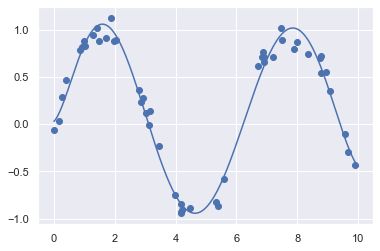

In [106]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = poly_model.predict(xfit.reshape(-1,1))

plt.scatter(x, y)
plt.plot(xfit, yfit);

The linear model through the use of 7th-order polynomial basis functions, can provide an excellent fit to this non-linear data.

## Predicting Bicycle Traffic

We predict the number of bicycle trips across Seattle's [Fremont Bridge](https://data.seattle.gov/Transportation/Fremont-Bridge-Bicycle-Counter/65db-xm6k) based on weather, season, holidays, and other factors.

We will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors such as temperature, precipitation, and daylight hours — affect the volume of bicycle traffic. NOAA makes available their daily [weather station data](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (we shall use station ID USW00024233) and we can easily use Pandas to join the two data sources.

We will perform linear and polynomial regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

Let's start by loading the two datasets, indexing by date:

In [107]:
import pandas as pd
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True)

In [108]:
counts.describe()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
count,144352.000000,144352.000000,144352.000000
mean,111.188013,50.529241,60.658772
std,141.260941,65.050403,87.812023
min,0.000000,0.000000,0.000000
25%,14.000000,6.000000,7.000000
50%,60.000000,28.000000,30.000000
75%,146.000000,68.000000,75.000000
max,1097.000000,698.000000,850.000000


In [109]:
counts.head(10)

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0
2019-11-01 05:00:00,20.0,9.0,11.0
2019-11-01 06:00:00,97.0,43.0,54.0
2019-11-01 07:00:00,299.0,120.0,179.0
2019-11-01 08:00:00,583.0,261.0,322.0


In [110]:
counts.tail(10)

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2021-08-31 14:00:00,106.0,45.0,61.0
2021-08-31 15:00:00,161.0,63.0,98.0
2021-08-31 16:00:00,234.0,78.0,156.0
2021-08-31 17:00:00,354.0,117.0,237.0
2021-08-31 18:00:00,282.0,84.0,198.0
2021-08-31 19:00:00,139.0,52.0,87.0
2021-08-31 20:00:00,95.0,38.0,57.0
2021-08-31 21:00:00,48.0,26.0,22.0
2021-08-31 22:00:00,24.0,15.0,9.0


In [111]:
weather.describe().T

,count,mean,std,min,25%,50%,75%,max
PRCP,1340.0,28.292537,62.763097,0.0,0.0,0.0,25.0,559.0
SNWD,1340.0,0.324627,4.479127,0.0,0.0,0.0,0.0,80.0
SNOW,1340.0,-29.545522,545.736003,-9999.0,0.0,0.0,0.0,173.0
TMAX,1340.0,166.672388,74.331651,-16.0,111.0,156.0,222.0,356.0
TMIN,1340.0,83.249254,50.563330,-71.0,44.0,83.0,122.0,183.0
AWND,1340.0,24.692537,274.396498,-9999.0,22.0,30.0,40.0,95.0
WDF2,1340.0,170.840299,296.343588,-9999.0,107.5,200.0,230.0,360.0
WDF5,1340.0,22.154478,1298.860605,-9999.0,120.0,205.0,240.0,360.0
WSF2,1340.0,64.513433,276.304370,-9999.0,54.0,67.0,89.0,192.0
WSF5,1340.0,-71.045522,1283.628567,-9999.0,67.0,89.0,112.0,264.0


In [112]:
weather.head(10)

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,128,50,47,100,90,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-01-02,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,109,0,0,106,28,45,180,200,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-03,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,8,0,0,117,72,23,180,170,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999
2012-01-04,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,203,0,0,122,56,47,180,190,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-05,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,13,0,0,89,28,61,200,220,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999
2012-01-06,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,25,0,0,44,22,22,180,180,...,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999,-9999
2012-01-07,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,72,28,23,170,180,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999
2012-01-08,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,100,28,20,160,200,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2012-01-09,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,43,0,0,94,50,34,200,200,...,-9999,-9999,-9999,-9999,-9999,1,1,-9999,-9999,-9999


In [113]:
weather.tail(10)

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,
2015-08-23,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,278,139,18,10,10,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,1,-9999,-9999
2015-08-24,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,239,122,23,190,190,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2015-08-25,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,256,122,34,350,360,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2015-08-26,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,283,139,17,30,40,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2015-08-27,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,294,144,21,230,200,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2015-08-28,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,5,0,0,233,156,26,230,240,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2015-08-29,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,325,0,0,222,133,58,210,210,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2015-08-30,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,102,0,0,200,128,47,200,200,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999
2015-08-31,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,189,161,58,210,210,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999


Next we will compute the total daily bicycle traffic, and put this in its own dataframe:

In [178]:
daily = counts.resample('d').sum()
daily['Total'] = daily['Fremont Bridge Total']
daily.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk,Total
Date,,,,
2012-10-03,7042.0,3520.0,3522.0,7042.0
2012-10-04,6950.0,3416.0,3534.0,6950.0
2012-10-05,6296.0,3116.0,3180.0,6296.0
2012-10-06,4012.0,2160.0,1852.0,4012.0
2012-10-07,4284.0,2382.0,1902.0,4284.0


In [177]:
daily = daily[['Total']] # remove other columns

print(daily.shape)
daily.head(10)

(1064, 1)


,Total
Date,
2012-10-03,7042.0
2012-10-04,6950.0
2012-10-05,6296.0
2012-10-06,4012.0
2012-10-07,4284.0
2012-10-08,7074.0
2012-10-09,7002.0
2012-10-10,6470.0
2012-10-11,6094.0


In [158]:
daily.tail(10)

,Total
Date,
2021-08-22,2230.0
2021-08-23,2749.0
2021-08-24,3255.0
2021-08-25,3116.0
2021-08-26,2694.0
2021-08-27,2485.0
2021-08-28,2973.0
2021-08-29,2634.0
2021-08-30,2374.0


The patterns of use generally vary from day to day; let's account for this in our data by adding binary columns that indicate the day of the week:

In [159]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

Similarly, we expect riders to behave differently on holidays. Let's add an indicator for this as well:

In [160]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

We also suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

(8, 17)

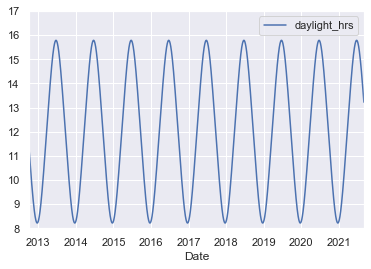

In [161]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

We can also add the **average temperature** and **total precipitation** to the data.
In addition to the inches of precipitation, also add a flag that indicates whether a day is dry (has zero precipitation):

In [162]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

Drop samples with null values

In [163]:
daily.dropna(axis=0, how='any', inplace=True)

Now we can take a look at our data:

In [164]:
daily.head(10)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.000000,0.1335,1.0
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.000000,0.1360,1.0
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.000000,0.1530,1.0
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.000000,0.1585,1.0
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.000000,0.1585,1.0
2012-10-08,7074.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.987503,0.000000,0.1445,1.0
2012-10-09,7002.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.929950,0.000000,0.1250,1.0
2012-10-10,6470.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10.872560,0.000000,0.1025,1.0
2012-10-11,6094.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.815345,0.000000,0.1055,1.0


In [165]:
daily.tail(10)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2015-08-23,4032.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.696740,0.000000e+00,0.2085,1.0
2015-08-24,8144.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.641653,0.000000e+00,0.1805,1.0
2015-08-25,8946.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.586282,0.000000e+00,0.1890,1.0
2015-08-26,8662.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,13.530639,0.000000e+00,0.2110,1.0
2015-08-27,8672.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.474738,0.000000e+00,0.2190,1.0
2015-08-28,5306.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.418591,3.051187e-07,0.1945,0.0
2015-08-29,1398.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.362212,1.983272e-05,0.1775,0.0
2015-08-30,2426.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.305611,6.224422e-06,0.1640,0.0
2015-08-31,5646.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.248802,0.000000e+00,0.1750,1.0


Save the preprocessed dataset for future use.

In [166]:
daily.to_csv('Bicycle_traffic_cleaned')

With this in place, we can choose the columns to use, and fit a linear regression model to our data.

In [167]:
column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)']
X = daily[column_names]
y = daily['Total']

print('Total number of days:', len(y))

Total number of days: 1064


In [168]:
# X - argument relates to the features
# y - argument relates to the labels
X_train = X.iloc[:900]
X_test = X.iloc[900:]
y_train = y[:900]
y_test = y[900:]

daily_train = pd.DataFrame(y_train) # for plot
daily_test = pd.DataFrame(y_test) # for plot

Define the ``PolynomialRegression`` model using ``make_pipeline``:

In [192]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [213]:
# fit a simple linear regression model
lin_model = LinearRegression()

lin_model.fit(X_train,y_train) 
daily_train['predicted_lin'] = lin_model.predict(X_train)
daily_test['predicted_lin'] = lin_model.predict(X_test)
# fit a linear regression model with polynomial basis

poly_model = PolynomialRegression(2)

poly_model.fit(X_train, y_train)
daily_train['predicted_poly'] = poly_model.predict(X_train)
daily_test['predicted_poly'] = poly_model.predict(X_test)

Finally, we can compare the total and predicted bicycle traffic visually:

Predictions on Training data with Linear Regression


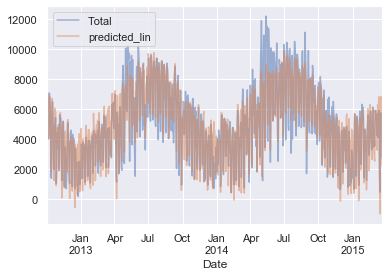

In [204]:
print('Predictions on Training data with Linear Regression')

daily_train[['Total', 'predicted_lin']].plot(alpha=0.5);

Predictions on Test data with Linear Regression


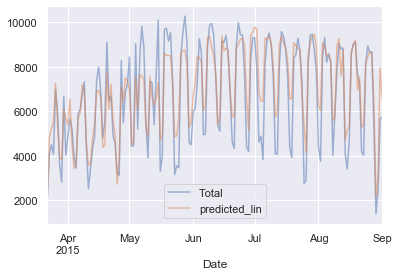

In [205]:
print('Predictions on Test data with Linear Regression')
daily_test[['Total', 'predicted_lin']].plot(alpha=0.5);

Predictions on Training data with Polynomial Regression of degree 2


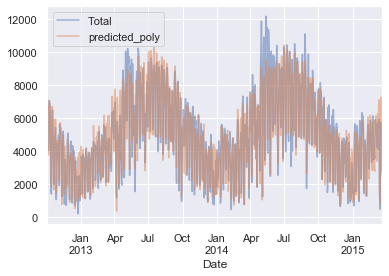

In [206]:
print('Predictions on Training data with Polynomial Regression of degree 2')

daily_train[['Total', 'predicted_poly']].plot(alpha=0.5);

Predictions on Test data with Polynomial Regression of degree 2


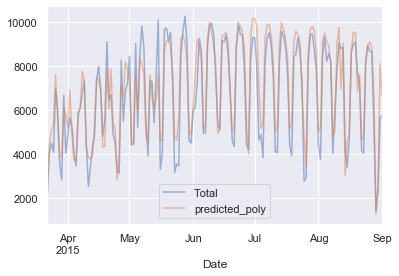

In [207]:
print('Predictions on Test data with Polynomial Regression of degree 2')

daily_test[['Total', 'predicted_poly']].plot(alpha=0.5);

**Polynomial regression with degree 2 predicts more accurately than naive linear regression.**

In [210]:
from sklearn import metrics
print('Linear Regression:')
print('Train RMSE:', np.sqrt(metrics.mean_squared_error(y_train, daily_train['predicted_lin']) ))
print('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_test, daily_test['predicted_lin']) ))

Linear Regression:
Train RMSE: 898.1305516351076
Test RMSE: 1024.686268652728


In [211]:
from sklearn import metrics
print('Polynomial Regression Degree 2:')
print('Train RMSE:', np.sqrt(metrics.mean_squared_error(y_train, daily_train['predicted_poly']) ))
print('Test RMSE:', np.sqrt(metrics.mean_squared_error(y_test, daily_test['predicted_poly'])))

Polynomial Regression Degree 2:
Train RMSE: 789.5661128336018
Test RMSE: 870.3719522369058


**However, polynomial regression with degree 3 will cause severe overfitting.**

In [154]:
poly_model = PolynomialRegression(3).fit(X_train, y_train)

daily_train['predicted_poly'] = poly_model.predict(X_train)
daily_test['predicted_poly'] = poly_model.predict(X_test)

Predictions on Training data with Polynomial Regression of degree 3


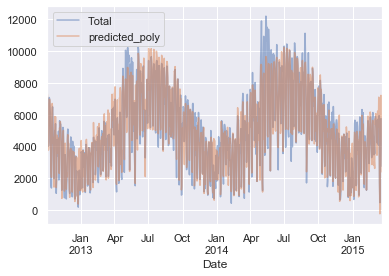

In [155]:
print('Predictions on Training data with Polynomial Regression of degree 3')

daily_train[['Total', 'predicted_poly']].plot(alpha=0.5);

Predictions on Test data with Polynomial Regression of degree 3


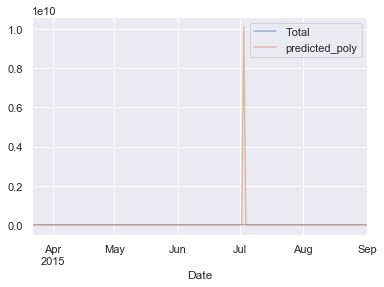

In [156]:
print('Predictions on Test data with Polynomial Regression of degree 3')

daily_test[['Total', 'predicted_poly']].plot(alpha=0.5);

**``pipeline`` class does not have the learned parameters as atrribute**, but we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [66]:
params = pd.Series(lin_model.coef_, index=X.columns)
params

Mon             1910.337800
Tue             2301.703288
Wed             2207.527047
Thu             1690.086066
Fri              544.573517
Sat            -4266.767335
Sun            -4387.460382
holiday        -4405.773912
daylight_hrs     519.534813
PRCP           -2667.056130
dry day         2197.428170
Temp (C)         284.672989
dtype: float64

## Question

If we want to predict traffic counts for the period from 2012 to 2021, are there any other features that could be significant in prediction?